# Super Simple Diffusion
A notebook to implement diffusion for educational purposes

Steps:
1. Sample points from two classes of normal distributions
2. Train a linear classifieer on these data
3. forward Diffusion
4. Denoising Diffusion
5. Make Plots



Source:
https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing

Some links:

  - [tiny-diffusion](https://github.com/tanelp/tiny-diffusion)
  - [nanoDDPM](https://github.com/charles214chen/nanoDiffusion)
  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import seaborn as sns
import pandas as pd
import warnings

warnings.filterwarnings('ignore')


In [ ]:
sigma = np.array([[1, 0], [0, 1]])
mu = np.array([7,7])

In [ ]:
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

# the function that I'm going to plot
def z_func(x, y):
    h, w = x.shape
    x_flat = x.reshape(-1)
    y_flat = y.reshape(-1)
    x1 = np.column_stack((x_flat, y_flat))
    results = np.apply_along_axis(gaussReward, 1, x1)
    return results.reshape(h,w)

def gauss2D(x):
    if x[0] <= 7:
        return 0.
    num = np.dot((x-mu).transpose(), np.linalg.inv(sigma))
    num = np.dot(num, (x-mu))
    num = np.exp(-(1/2) * num)
    denom = np.sqrt((2*np.pi)**2 * np.linalg.det(sigma))
    return num/denom

def gaussReward(x):

    with torch.no_grad():
            curr_target = np.array([mu[0], x[1]])

    # return -np.sqrt(np.sum((x - curr_target)**2))
    return 1/1-np.exp(-np.sqrt(np.sum((x-curr_target)**2)))

    if x[0] <= 7:
        return 0.
    return np.exp(-np.sqrt(np.sum((x-mu)**2)))
    # num = np.dot((x-mu).transpose(), np.linalg.inv(sigma))
    # num = np.dot(num, (x-mu))
    # num = np.exp(-(x-mu))
    # denom = np.sqrt((2*np.pi)**2 * np.linalg.det(sigma))
    # return num/denom


x = arange(0,10,0.1)
y = arange(10,0,-0.1)
X,Y = meshgrid(x, y) # grid of point
Z = z_func(X, Y) # evaluation of the function on the grid

im = imshow(Z,cmap="Blues") # drawing the function
# adding the Contour lines with labels
# cset = contour(Z, arange(0.02, 0.12, 0.04), linewidths=2, cmap=cm.Set2)
# clabel(cset,inline=True,fmt='%1.2f',fontsize=10)
colorbar(im) # adding the colobar on the right
# latex fashion title
# title('$z=(1-x^2+y^3) e^{-(x^2+y^2)/2}$')
plt.xticks(ticks=np.arange(0,100,20), labels=np.arange(0,10,2))
plt.yticks(ticks=np.arange(0,100,20), labels=np.arange(10,0,-2))
plt.axis([0, 100.5 ,100.5, 0])
plt.grid()
show()

## Step 1: Data generation


In [ ]:
# cov = np.array([[1, 0], [0, 1]])
# x_c1 = np.random.multivariate_normal([5, 5], cov, size=1000)
# y_c1 = np.zeros_like(x_c1[:,[1]])

# x_c2 = np.random.multivariate_normal([-5, -5], cov, size=100)
# y_c2 = np.zeros_like(x_c2[:,[1]])+1

# fig, ax = plt.subplots()

# ax.scatter(x_c1[:, 0], x_c1[:, 1], c='b', marker = 's')
# ax.axis([0, 10 ,0, 10])

# circle1 = plt.Circle((5, 5), 2.33, color='r', fill=False)
# ax.add_patch(circle1)

# circle2 = plt.Circle((5, 5), 1.28, color='r', fill=False)
# ax.add_patch(circle2)

# ax.scatter(x_c2[:, 0], x_c2[:, 1],  c='r', marker = 's')
# ax.axis([-10, 10 ,-10, 10])

# plt.axis('equal')
# plt.grid()
# plt.show()

In [ ]:
outputs_dir = 'outputs'

In [ ]:
LOAD_FROM_FILE = True

if LOAD_FROM_FILE:
    x_c1 = np.load(f'{outputs_dir}/data.npy')
else:
    cov = np.array([[3, 0], [0, 3]])
    x_c1 = np.random.multivariate_normal([5, 5], cov, size=1000)

data_df = pd.DataFrame({'x1': x_c1[:, 0], 'x2': x_c1[:, 1]})

fig, ax = plt.subplots()
sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax = ax, cmap="Blues")
ax.axis([0, 10 ,0, 10])

# plt.savefig(f'{outputs_dir}/data_dist.png', dpi=300)
plt.show()

In [ ]:
# np.save(f'{outputs_dir}/data.npy', x_c1)

In [ ]:
# opt_cov = np.array([[1, 0], [0, 1]])
# opt_x = np.random.multivariate_normal([7, 7], opt_cov, size=1000)

# data_df = pd.DataFrame({'x1': opt_x[:, 0], 'x2': opt_x[:, 1]})

# fig, ax = plt.subplots()
# sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
# ax.axis([0, 10 ,0, 10])

# plt.savefig(f'{outputs_dir}/reward_dist.png', dpi=300)

In [ ]:
# np.save(f'{outputs_dir}/reward.npy', opt_x)

In [ ]:
def reward_func(data, radius):
    results = []
    for sample in data:
        # print(sample.shape)
        data_x, data_y = sample
        if data_x**2 + data_x**2 <= radius**2:
            results.append(1)
        else:
            results.append(0)

    return results

def simple_reward(data, target):
    results = []
    for sample in data:
        results.append(-np.sqrt(((sample - target)**2).sum()))
    return results

def ng_simple_reward(data, target):
    results = []
    for sample in data:
        results.append(1/(1 + np.exp(- (sample[0] - target))) )
    return results

# results = simple_reward(x_c1, np.array([7, 7]))
results = ng_simple_reward(x_c1, 7)


data_df = pd.DataFrame({'x1': x_c1[:, 0], 'x2': x_c1[:, 1], 'results':results})

fig, ax = plt.subplots()
sns.scatterplot(data_df, x='x1', y='x2', hue='results', legend=False, ax=ax, palette="Blues")
ax.axvline(7)
ax.axis([0, 10 ,0, 10])

# plt.savefig(f'{outputs_dir}/reward_func.png', dpi=300)
plt.show()

## Step 3: Diffusion

Reference: https://github.com/tanelp/tiny-diffusion/tree/master

In [2]:
'''Different methods for positional embeddings. These are not essential for understanding DDPMs, but are relevant for the ablation study.'''

import torch
from torch import nn
from torch.nn import functional as F


class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.Tensor([10000.0])) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size


class LinearEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x / self.size * self.scale
        return x.unsqueeze(-1)

    def __len__(self):
        return 1


class LearnableEmbedding(nn.Module):
    def __init__(self, size: int):
        super().__init__()
        self.size = size
        self.linear = nn.Linear(1, size)

    def forward(self, x: torch.Tensor):
        return self.linear(x.unsqueeze(-1).float() / self.size)

    def __len__(self):
        return self.size


class IdentityEmbedding(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor):
        return x.unsqueeze(-1)

    def __len__(self):
        return 1


class ZeroEmbedding(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor):
        return x.unsqueeze(-1) * 0

    def __len__(self):
        return 1


class PositionalEmbedding(nn.Module):
    def __init__(self, size: int, type: str, **kwargs):
        super().__init__()

        if type == "sinusoidal":
            self.layer = SinusoidalEmbedding(size, **kwargs)
        elif type == "linear":
            self.layer = LinearEmbedding(size, **kwargs)
        elif type == "learnable":
            self.layer = LearnableEmbedding(size)
        elif type == "zero":
            self.layer = ZeroEmbedding()
        elif type == "identity":
            self.layer = IdentityEmbedding()
        else:
            raise ValueError(f"Unknown positional embedding type: {type}")

    def forward(self, x: torch.Tensor):
        return self.layer(x)

In [3]:
class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))


class MLP(nn.Module):
    def __init__(self, hidden_size: int = 128, hidden_layers: int = 3, emb_size: int = 128,
                 time_emb: str = "sinusoidal", input_emb: str = "sinusoidal"):
        super().__init__()

        self.time_mlp = PositionalEmbedding(emb_size, time_emb)
        self.input_mlp1 = PositionalEmbedding(emb_size, input_emb, scale=25.0)
        self.input_mlp2 = PositionalEmbedding(emb_size, input_emb, scale=25.0)

        concat_size = len(self.time_mlp.layer) + \
            len(self.input_mlp1.layer) + len(self.input_mlp2.layer)
        layers = [nn.Linear(concat_size, hidden_size), nn.GELU()]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))
        layers.append(nn.Linear(hidden_size, 2))
        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, x, t):
        x1_emb = self.input_mlp1(x[:, 0])
        x2_emb = self.input_mlp2(x[:, 1])
        t_emb = self.time_mlp(t)
        x = torch.cat((x1_emb, x2_emb, t_emb), dim=-1)
        x = self.joint_mlp(x)
        return x


In [54]:
class NoiseScheduler():
    def __init__(self,
                 num_timesteps=1000,
                 beta_start=0.0001,
                 beta_end=0.02,
                 beta_schedule="linear"):

        self.num_timesteps = num_timesteps
        if beta_schedule == "linear":
            self.betas = torch.linspace(
                beta_start, beta_end, num_timesteps, dtype=torch.float32)
        elif beta_schedule == "quadratic":
            self.betas = torch.linspace(
                beta_start ** 0.5, beta_end ** 0.5, num_timesteps, dtype=torch.float32) ** 2

        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(
            self.alphas_cumprod[:-1], (1, 0), value=1.)

        # required for self.add_noise
        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5

        # required for reconstruct_x0
        self.sqrt_inv_alphas_cumprod = torch.sqrt(1 / self.alphas_cumprod)
        self.sqrt_inv_alphas_cumprod_minus_one = torch.sqrt(
            1 / self.alphas_cumprod - 1)

        # required for q_posterior
        self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_mean_coef2 = (1. - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1. - self.alphas_cumprod)

    def reconstruct_x0(self, x_t, t, noise):
        s1 = self.sqrt_inv_alphas_cumprod[t]
        s2 = self.sqrt_inv_alphas_cumprod_minus_one[t]
        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)
        return s1 * x_t - s2 * noise

    def q_posterior(self, x_0, x_t, t):
        s1 = self.posterior_mean_coef1[t]
        s2 = self.posterior_mean_coef2[t]
        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)
        mu = s1 * x_0 + s2 * x_t
        return mu

    def get_variance(self, t):
        if t == 0:
            return 0

        variance = self.betas[t] * (1. - self.alphas_cumprod_prev[t]) / (1. - self.alphas_cumprod[t])
        variance = variance.clip(1e-20)
        return variance

    def step(self, model_output, timestep, sample):
        t = timestep
        pred_original_sample = self.reconstruct_x0(sample, t, model_output)
        pred_prev_sample = self.q_posterior(pred_original_sample, sample, t)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output)
            variance = (self.get_variance(t) ** 0.5) * noise

        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample

    def step_new(self, model_output, timestep, sample, grad, scale = 0.5):

        t = timestep

        ## Change
        res = (scale * self.sqrt_one_minus_alphas_cumprod[t] * grad.float())
        model_output = model_output - (scale * self.sqrt_one_minus_alphas_cumprod[t] * grad.float())

        pred_original_sample = self.reconstruct_x0(sample, t, model_output)
        pred_prev_sample = self.q_posterior(pred_original_sample, sample, t)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output)
            variance = (self.get_variance(t) ** 0.5) * noise

        pred_prev_sample = pred_prev_sample + variance

        return res, pred_prev_sample


    def step_modified(self, model_output, timestep, sample, prev_timestep = None):
        t = timestep

        if prev_timestep is None:
            prev_timestep = t

        pred_original_sample = self.reconstruct_x0(sample, t, model_output)
        # pred_prev_sample = self.q_posterior(pred_original_sample, sample, t)
        pred_prev_sample = self.q_posterior(pred_original_sample, sample, prev_timestep)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output)
            variance = (self.get_variance(t) ** 0.5) * noise

        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample

    def add_noise(self, x_start, x_noise, timesteps):
        s1 = self.sqrt_alphas_cumprod[timesteps]
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps]

        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)

        return s1 * x_start + s2 * x_noise

    def __len__(self):
        return self.num_timesteps

In [6]:
from torch.utils.data import TensorDataset, DataLoader
from tqdm.auto import tqdm

In [55]:
# Define beta schedule
T = 1000
noise_scheduler = NoiseScheduler(
      num_timesteps=T,
      beta_schedule="linear")

def forward_diffusion_sample(x_0, t):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)

    return noise_scheduler.add_noise(x_0, noise, t)

In [ ]:
sample1 = torch.from_numpy(x_c1[0, :]).unsqueeze(dim=0)

num_samples = 20
stepsize = int(T/num_samples)

fig, ax = plt.subplots()
ax.plot(sample1[0][0], sample1[0][1], c= 'b', marker = 's')
ax.axis([0, 10 , 0, 10])

# plt.grid()
for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)

    sample1 = forward_diffusion_sample(sample1, t)[0]
    ax.plot(sample1[0], sample1[1], '.', c= 'b', alpha=0.5, markersize=1)
    ax.annotate(idx, (sample1[0], sample1[1]), c='b', fontsize=6)

In [ ]:
# data_c1, data_c2 = torch.from_numpy(x_c1.astype(np.float32)), torch.from_numpy(x_c2.astype(np.float32))

data_c1 = torch.from_numpy(x_c1.astype(np.float32))

# data_x = torch.cat([data_c1, data_c2], dim=0)
# data_y = torch.cat([torch.zeros_like(data_c1[:,1]), torch.ones_like(data_c2[:,1])], dim=0)

# data_x = data_c1
# data_y = torch.zeros_like(data_c1[:,1])

# simpledataset = TensorDataset(data_x, data_y) # create your datset
simpledataset = TensorDataset(data_c1) # create your datset
dataloader = DataLoader(simpledataset, shuffle=True, batch_size=32) # create your dataloader

In [ ]:
model = MLP(
        hidden_size=128,
        hidden_layers=3,
        emb_size=128,
        time_emb="sinusoidal",
        input_emb="identity")

optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-3,
    )

num_epochs = 200

print("Training model...")

progress_bar = tqdm(total=num_epochs)
for epoch in range(num_epochs):
    model.train()
    progress_bar.set_description(f"Epoch {epoch}")

    losses = []
    for step, batch in enumerate(dataloader):
        batch = batch[0]

        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        noise = torch.randn(batch.shape)
        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        noise_pred = model(noisy, timesteps)
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward(loss)
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        losses.append(loss.detach().item())

    progress_bar.update(1)
    logs = {"loss": sum(losses)/len(losses)}
    progress_bar.set_postfix(**logs)

progress_bar.close()


In [ ]:
model.eval()
sample = torch.randn(1, 2)

fig, ax = plt.subplots()
ax.plot(sample[0][0], sample[0][1], c= 'b', marker = 's')
ax.axis([0, 10 , 0, 10])

plt.grid()

timesteps = list(range(len(noise_scheduler)))[::-1]
for i, t in enumerate(tqdm(timesteps)):
      t = torch.from_numpy(np.repeat(t, 1)).long()
      with torch.no_grad():
          residual = model(sample, t)
      sample = noise_scheduler.step(residual, t[0], sample)
      if t % 100 == 0:
          ax.plot(sample[0][0], sample[0][1], '.', c= 'b', alpha=0.5, markersize=5)
          ax.annotate(T- t.item(), (sample[0][0], sample[0][1]), c='b', fontsize=6)

In [ ]:
torch.save(model, 'model.pt')

In [10]:
num_samples = 1000
sample_hold = torch.randn(num_samples, 2)

  0%|          | 0/1000 [00:00<?, ?it/s]

(0.0, 10.0, 0.0, 10.0)

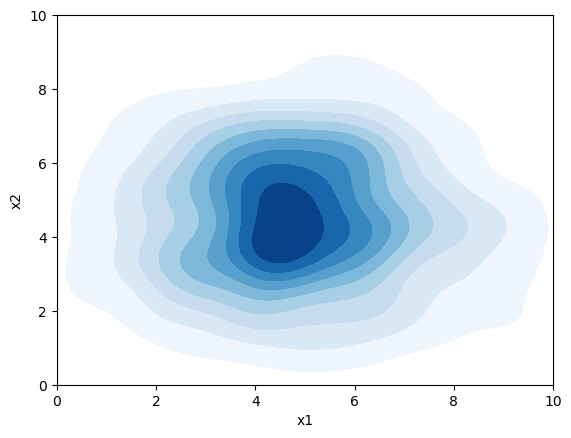

In [72]:
model.eval()
sample = sample_hold

# fig, ax = plt.subplots()
# ax.plot(sample[0][0], sample[0][1], c= 'b', marker = 's')
# ax.axis([-10, 10 ,-10, 10])

timesteps = list(range(len(noise_scheduler)))[::-1]
for i, t in enumerate(tqdm(timesteps)):
      t = torch.from_numpy(np.repeat(t, num_samples)).long()
      with torch.no_grad():
          residual = model(sample, t)

      sample = noise_scheduler.step(residual, t[0], sample)

      # if t[0].item() % 10 == 0:
      #     ax.plot(sample[0][0], sample[0][1], '.', c= 'b', alpha=0.5, markersize=1)
      #     ax.annotate(i, (sample[0][0], sample[0][1]), c='b', fontsize=6)

data_df = pd.DataFrame({'x1': sample[:, 0], 'x2': sample[:, 1]})

fig, ax = plt.subplots()

# sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
ax.scatter(sample[:, 0], sample[:, 1], c='b', alpha=0.5, s=10)
ax.axis([0, 10 , 0, 10])

# plt.grid()
# plt.show()
# plt.savefig(f'{outputs_dir}/uncond_gen.png',dpi=300)

In [ ]:
print(f'mean {np.mean(sample.detach().numpy(), axis=0)}')
print(f'cov {np.cov(sample.detach().numpy().T)}')

## Controlled Denoising

In [40]:
class Reward(nn.Module):

    def __init__(self, target_val:int = 7):
        super().__init__()
        self.target = target_val

    def forward(self, x):
        isnumpy = False
        if type(x) is np.ndarray:
            isnumpy = True
            x = torch.tensor(x).unsqueeze(0)
            
        with torch.no_grad():
            
            curr_target = torch.tensor([[self.target, self.target]]).long()

            # if x[0][1].item() <= self.target:
            #     curr_target = torch.tensor([[x[0][0].item(), x[0][1].item()]]).long()
            # else:
            #     curr_target = torch.tensor([[self.target, self.target]]).long()

        if isnumpy:
            return (curr_target - x).pow(2).sum().sqrt().item()
        else:
            return (curr_target - x).pow(2).sum().sqrt()

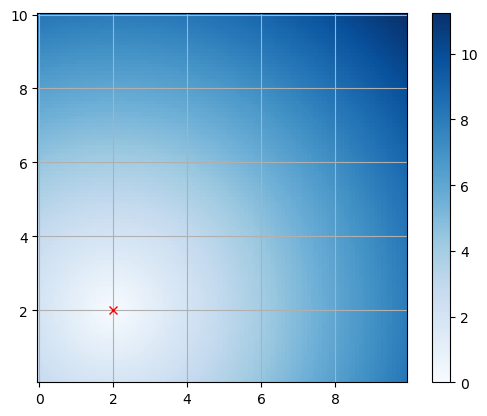

In [89]:
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

reward_fn = Reward(target_val=2)

# the function that I'm going to plot
def z_func(x, y):
    h, w = x.shape
    x_flat = x.reshape(-1)
    y_flat = y.reshape(-1)
    x1 = np.column_stack((y_flat, x_flat))
    results = np.apply_along_axis(reward_fn, 1, x1)
    return results.reshape(h,w)


x = arange(0,10,0.1)
y = arange(10,0,-0.1)
X,Y = meshgrid(x, y) # grid of point
Z = z_func(X, Y) # evaluation of the function on the grid

im = imshow(Z, cmap="Blues") # drawing the function
colorbar(im) # adding the colobar on the right
plt.xticks(ticks=np.arange(0,100,20), labels=np.arange(0,10,2))
plt.yticks(ticks=np.arange(0,100,20), labels=np.arange(10,0,-2))
# plt.axis([0, 100.5 ,100.5, 0])
plt.plot((reward_fn.target/0.1), (100 - reward_fn.target/0.1), marker='x', color='red')
plt.grid()
show()

  0%|          | 0/50 [00:00<?, ?it/s]

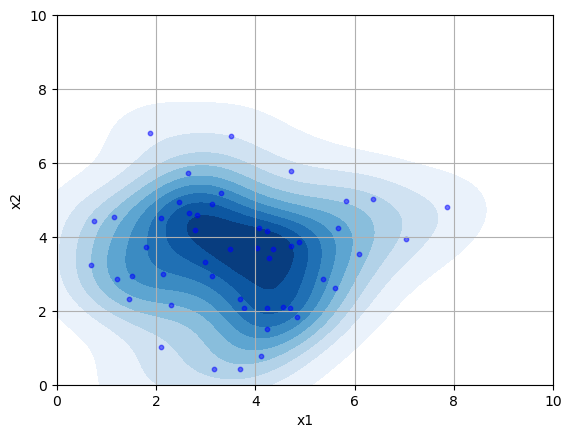

In [95]:
import copy

PLOT_TRAJECTORY = False

# Load trained model
model = torch.load('model.pt')
model.eval()

sample = sample_hold

def cond_fn(x):
    with torch.enable_grad():
        x_in = x.detach().requires_grad_(True)
        out = reward_fn(x_in)
        # out = torch.nn.MSELoss()(x_in, curr_target)
        return out, torch.autograd.grad(out, x_in)[0]

result = []

# for idx in tqdm(range(num_samples), total=num_samples):
for idx in tqdm(range(50), total=50):

    if PLOT_TRAJECTORY:
        fig, ax = plt.subplots()
        ax.plot(sample[idx][0], sample[idx][1], c= 'b', marker = 's')
        # ax.axis([-10, 10 , -10, 10])

    curr_sample = copy.deepcopy(sample[idx]).unsqueeze(0)

    timesteps = list(range(len(noise_scheduler)))[::-1]
    for i, t in enumerate(timesteps):
          t = torch.from_numpy(np.repeat(t, 1)).long()
          with torch.no_grad():
              residual = model(curr_sample, t)

          pred_x0 = noise_scheduler.reconstruct_x0(residual, t[0], curr_sample)
          loss, grad = cond_fn(pred_x0)

          # curr_sample = noise_scheduler.step(residual, t[0], curr_sample)
          res, curr_sample = noise_scheduler.step_new(residual, t[0], curr_sample, grad, scale=0.4)

          if np.any(np.isnan(curr_sample.detach().numpy()[0])):
              raise ValueError(f'{curr_sample} {pred_x0} {grad}')

          if t[0].item() % 100 == 0 and PLOT_TRAJECTORY:
              ax.plot(curr_sample[0][0], curr_sample[0][1], '.', c= 'b', alpha=0.5, markersize=1)
              ax.annotate(str(i) + '_' + str(round(loss.item(), 2)), (curr_sample[0][0], curr_sample[0][1]), c='b', fontsize=6)

    if PLOT_TRAJECTORY:
        plt.show()
        plt.close()

    result.append(curr_sample)

result = torch.cat(result, dim=0)


data_df = pd.DataFrame({'x1': result[:, 0], 'x2': result[:, 1]})

fig, ax = plt.subplots()

sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
ax.scatter(result[:, 0], result[:, 1], c='b', alpha=0.5, s=10)
ax.axis([0, 10 , 0, 10])

plt.grid()
plt.show()
# plt.savefig(f'{outputs_dir}/cond_gen_s05.png',dpi=300)

In [ ]:
import copy

model.eval()
sample = sample_hold
kval = 5

reward_fn = Reward(target_val=7)

result = []

# for idx in tqdm(range(num_samples), total=num_samples):
for idx in tqdm(range(10), total=10):

    gen_reward = []
    gen_sample = []

    for k in range(kval):

        curr_sample = copy.deepcopy(sample[idx]).unsqueeze(0)

        timesteps = list(range(len(noise_scheduler)))[::-1]
        for i, t in enumerate(timesteps):
            t = torch.from_numpy(np.repeat(t, 1)).long()
            with torch.no_grad():
                residual = model(curr_sample, t)

            curr_sample = noise_scheduler.step(residual, t[0], curr_sample)

            if np.any(np.isnan(curr_sample.detach().numpy()[0])):
                raise ValueError(f'{curr_sample} {pred_x0} {grad}')
            
        reward = reward_fn(curr_sample)
        gen_reward.append(reward.unsqueeze(0))
        gen_sample.append(copy.deepcopy(curr_sample))

    select_ind = torch.max(torch.cat(gen_reward), dim=0)[1]
    result.append(gen_sample[select_ind.item()])

result = torch.cat(result, dim=0)


data_df = pd.DataFrame({'x1': result[:, 0], 'x2': result[:, 1]})

fig, ax = plt.subplots()

# sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
ax.scatter(result[:, 0], result[:, 1], c='b', alpha=0.5, s=10)
ax.axvline(7)
ax.axis([0, 10 , 0, 10])

# plt.grid()
plt.show()
# plt.savefig(f'{outputs_dir}/cond_gen_s05.png',dpi=300)

In [ ]:
print(f'mean {np.mean(result.detach().numpy(), axis=0)}')
print(f'cov {np.cov(result.detach().numpy().T)}')

In [ ]:
print(f'mean {np.mean(result.detach().numpy(), axis=0)}')
print(f'cov {np.cov(result.detach().numpy().T)}')

In [ ]:
def multivariate_normal(x, d, mean, covariance):
    """pdf of the multivariate normal distribution."""
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))

In [ ]:
result_mean = np.mean(result.detach().numpy(), axis=0)
result_std = np.cov(result.detach().numpy().T)

results_prob = [multivariate_normal(x, 2, result_mean, result_std) for x in (result.detach().numpy())]

In [ ]:
sample_mean = np.mean(sample.detach().numpy(), axis=0)
sample_std = np.cov(sample.detach().numpy().T)

sample_prob = [multivariate_normal(x, 2, sample_mean, sample_std) for x in (sample.detach().numpy())]

In [ ]:
F.kl_div(torch.Tensor(sample_prob), torch.Tensor(results_prob))

In [ ]:
data_df = pd.DataFrame({'x1': sample[:, 0], 'x2': sample[:, 1], 'results':sample_prob})

fig, ax = plt.subplots()

g = sns.scatterplot(data_df, x='x1', y='x2', hue='results', ax=ax, palette="Blues")

# ax.axis([0, 10 ,0, 10])

In [ ]:
data_df = pd.DataFrame({'x1': result[:, 0], 'x2': result[:, 1], 'results':results_prob})

fig, ax = plt.subplots()

g = sns.scatterplot(data_df, x='x1', y='x2', hue='results', ax=ax, palette="Blues")

# ax.axis([0, 10 ,0, 10])

In [ ]:
import copy

model.eval()
noise_samples = 5
num_samples = 10
sample = torch.randn(num_samples, 2)

reward_fn = Reward()

result = []

for idx in tqdm(range(num_samples), total=num_samples):

    curr_sample = copy.deepcopy(sample[idx]).unsqueeze(0)

    timesteps = list(range(len(noise_scheduler)))[::-1]
    for i, t in enumerate(timesteps):
          t = torch.from_numpy(np.repeat(t, 1)).long()
          with torch.no_grad():
              residual = model(curr_sample, t)

          next_samples = []
          rewards = []
          prev_timestep = torch.from_numpy(np.repeat(t[0].item() - 1, 1)).long()

          for idx in range(noise_samples):
              sample_temp = copy.deepcopy(curr_sample)

              # compute the realization of previous noisy sample x_t -> x_t-1
              sample_temp = noise_scheduler.step(residual, t[0], sample_temp)

              # predict the noise residual
              with torch.no_grad():
                  residual_temp = model(sample_temp, prev_timestep)

              pred_x0 = noise_scheduler.reconstruct_x0(residual, t[0], sample_temp)

              reward = reward_fn(pred_x0)
              rewards.append(reward.unsqueeze(0))
              next_samples.append(sample_temp)

              # print(sample_temp.shape)

          select_ind = torch.max(torch.cat(rewards), dim=0)[1]

          next_samples = torch.cat(next_samples, dim=0)

          curr_sample = next_samples[select_ind.item()]
          curr_sample = curr_sample.unsqueeze(0)

          # next_samples = next_samples.permute(1,0,2)
          # curr_sample = torch.cat([x[select_ind[idx].item()].unsqueeze(0) for idx, x in enumerate(next_samples)], dim=0) # TODO: Make it efficient

          # if t[0].item() % 10 == 0:
          #     ax.plot(sample[0][0], sample[0][1], '.', c= 'b', alpha=0.5, markersize=1)
          #     ax.annotate(i, (sample[0][0], sample[0][1]), c='b', fontsize=6)

    result.append(curr_sample)

result = torch.cat(result, dim=0)

fig, ax = plt.subplots()

ax.scatter(result[:, 0], result[:, 1], c='b', alpha=0.5, s=10)
ax.axis([0, 10 , 0, 10])

plt.grid()
# plt.show()
# plt.savefig('cond_gen_s1.png',dpi=300)

In [ ]:
import copy

target = torch.tensor([[7,7]]).long()

def compute_reward(x):
    return -(x - target).pow(2).sum(1).sqrt()

In [ ]:
target = torch.tensor([[7,7]]).long()
target.repeat(1000, 1).shape

In [ ]:
model.eval()
num_samples = 1
noise_samples = 0
sample = torch.randn(num_samples, 2)

target = torch.tensor([[7,7]]).to(torch.float)
# target = target.repeat(num_samples, 1)

fig, ax = plt.subplots()
ax.plot(sample[0][0], sample[0][1], c= 'b', marker = 's')
ax.axis([-10, 10 ,-10, 10])

# plt.grid()

reward_model = nn.MSELoss()

timesteps = list(range(len(noise_scheduler)))[::-1]
for i, t in enumerate(tqdm(timesteps)):
      t = torch.from_numpy(np.repeat(t, num_samples)).long()
      with torch.no_grad():
          residual = model(sample, t)

      if noise_samples > 0:
          next_samples = []
          rewards = []
          prev_timestep = torch.from_numpy(np.repeat(t[0].item() - 1, num_samples)).long()

          for idx in range(noise_samples):
              sample_temp = copy.deepcopy(sample)

              # compute the realization of previous noisy sample x_t -> x_t-1
              sample_temp = noise_scheduler.step(residual, t[0], sample_temp)

              # predict the noise residual
              with torch.no_grad():
                  residual_temp = model(sample_temp, prev_timestep)

              pred_clean = noise_scheduler.step_modified(residual_temp, prev_timestep[0], sample_temp, timesteps[-1])

              reward = compute_reward(pred_clean)
              rewards.append(reward.unsqueeze(0))
              next_samples.append(sample_temp.unsqueeze(0))

          select_ind = torch.max(torch.cat(rewards), dim=0)[1]

          next_samples = torch.cat(next_samples, dim=0)
          next_samples = next_samples.permute(1,0,2)
          sample = torch.cat([x[select_ind[idx]].unsqueeze(0) for idx, x in enumerate(next_samples)], dim=0) # TODO: Make it efficient

      else:
          # sample = noise_scheduler.step(residual, t[0], sample)

          print(residual.shape)

          with torch.no_grad():
            pred_clean = noise_scheduler.step_modified(residual, prev_timestep[0], satimesteps[-1])


          pred_clean.requires_grad_(True)
          reward_model.zero_grad()
          reward = reward_model(pred_clean, target)
          reward.backward()

          # print(reward)
          # print(pred_clean.grad)

          ## Changes
          sample = noise_scheduler.step_new(residual, t[0], sample, pred_clean.grad)

          # break


      if t[0].item() % 10 == 0:
          ax.plot(sample[0][0], sample[0][1], '.', c= 'b', alpha=0.5, markersize=1)
          ax.annotate(i, (sample[0][0], sample[0][1]), c='b', fontsize=6)

          for idx in range(noise_samples):
              ax.plot(next_samples[idx][0][1], next_samples[idx][0][1], '.', c= 'r', alpha=0.5, markersize=10)

      # break

# fig, ax = plt.subplots()

# ax.plot(target[0][0], target[0][1], c='r', marker = 's', markersize=5)
# ax.scatter(sample[:, 0], sample[:, 1], c='b', alpha=0.5, s=10)
# ax.axis([0, 10 , 0, 10])

# data_df = pd.DataFrame({'x1': sample[:, 0], 'x2': sample[:, 1]})

# fig, ax = plt.subplots()
# sns.scatterplot(data_df, x='x1', y='x2', ax=ax, palette="Blues")
# ax.axis([0, 10 ,0, 10])

# plt.savefig('bestofk.png', dpi=300)

# plt.grid()
# plt.show()

In [ ]:
import seaborn as sns
import pandas as pd

In [ ]:
dist = - (data_c1 - target).pow(2).sum(1).sqrt()

In [ ]:
df = pd.DataFrame({'data_x1': data_c1[:, 0], 'data_x2': data_c1[:, 1], 'dist': dist})

fig, ax = plt.subplots()
sns.scatterplot(df, x='data_x1', y='data_x2', hue='dist', ax=ax)
ax.plot(target[0][0], target[0][1], c='r', marker = 's', markersize=5)
ax.axis([0, 10 ,0, 10])
ax.grid()


## Step 3: The forward process


In [ ]:

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    # print('batch_size: ', batch_size)
    # print('out: ', out)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 200
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [ ]:
sample1 = torch.from_numpy(x_c1[0, :])
sample2 = torch.from_numpy(x_c2[0, :])
num_samples = 20
stepsize = int(T/num_samples)

fig, ax = plt.subplots()
ax.plot(sample1[0], sample1[1], c= 'b', marker = 's')
ax.axis([-10, 10 ,-10, 10])
ax.plot(sample2[0], sample2[1], c= 'r', marker = 's')

plt.grid()
for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    sample1, noise = forward_diffusion_sample(sample1, t)
    sample2, noise = forward_diffusion_sample(sample2, t)
    ax.plot(sample1[0], sample1[1], '.', c= 'b', alpha=0.5, markersize=1)
    ax.annotate(idx, (sample1[0], sample1[1]), c='b', fontsize=6)
    ax.plot(sample2[0], sample2[1], '.', c= 'r', alpha=0.5, markersize=1)
    ax.annotate(idx, (sample2[0], sample2[1]), c='r', fontsize=6)

    # print('sample:', sample)
    # show_tensor_image(image)

## Step 4, denoising diffusion

In [ ]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model